#  **Breast Tumor Classification Using Histopathological Images**

##  **Introduction**
Breast cancer is one of the most prevalent and life-threatening diseases among women worldwide.  
Early and accurate diagnosis using histopathological images can significantly improve treatment outcomes.  

This project aims to develop a **Convolutional Neural Network (CNN)** capable of classifying **benign vs malignant** tumor tissue images using the **BreakHis dataset**.  

###  **Research Questions**
1. Can CNN models accurately classify benign vs malignant tumor tissue images?
2. Which visual features (texture, shape, patterns) are most influential, and can explainability methods such as **Grad-CAM** highlight them?
3. How does model performance vary across magnification levels (200× and 400×), and can models generalize across magnifications?

###  **Dataset Information**
- **Name:** BreakHis – Breast Cancer Histopathological Database  
- **Source:** [Mendeley Data – BreakHis Dataset](https://data.mendeley.com/datasets/jxwvdwhpc2/1)  
- **Contributors:** Mayke Pereira et al., Instituto Federal de Educação, Ciência e Tecnologia do Espírito Santo, Brazil  
- **Data Type:** RGB images (224 × 224 px) of breast-tumor tissues at magnifications 40×, 100×, 200×, 400×  
- **Labels:** Benign (0) / Malignant (1)


# **Setup and Dataset Download**

In [1]:
!apt-get install wget -q
!wget -O breakhis.zip "https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/jxwvdwhpc2-1.zip"
!unzip -q breakhis.zip -d /content/breakhis_dataset

import os
base_dir = "/content/breakhis_dataset"
print(" Dataset downloaded and extracted at:", base_dir)


Reading package lists...
Building dependency tree...
Reading state information...
wget is already the newest version (1.21.2-2ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.
--2025-10-06 14:52:33--  https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/jxwvdwhpc2-1.zip
Resolving prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)... 52.218.56.0, 52.92.3.58, 3.5.67.217, ...
Connecting to prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)|52.218.56.0|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1795182968 (1.7G) [application/zip]
Saving to: ‘breakhis.zip’

breakhis.zip        100%[===================>]   1.67G  27.1MB/s    in 61s     

2025-10-06 14:53:35 (28.0 MB/s) - ‘breakhis.zip’ saved [1795182968/1795182968]

 Dataset downloaded and extracted at: /content/breakhis_dataset


In [2]:

#  UNZIP INNER DATASET ARCHIVE


inner_zip = "/content/breakhis_dataset/BreakHis - Breast Cancer Histopathological Database/dataset_cancer_v1.zip"
extract_dir = "/content/breakhis_dataset/final_dataset"

# Unzip the nested archive
!unzip -q "$inner_zip" -d "$extract_dir"

# Verify extraction
import os
for root, dirs, files in os.walk(extract_dir):
    print(root, "->", len(files), "files")
    break

print(" Inner dataset extracted successfully at:", extract_dir)


/content/breakhis_dataset/final_dataset -> 0 files
 Inner dataset extracted successfully at: /content/breakhis_dataset/final_dataset


##  **Libraries and Initial Inspection**
We’ll import TensorFlow and Keras for model development, and Matplotlib / Seaborn for visual analysis.  
Let’s verify the folder structure and preview the dataset hierarchy.


In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2
magnification = "200X"  # choose among '40X', '100X', '200X', '400X'

base_dir = f"/content/breakhis_dataset/final_dataset/dataset_cancer_v1/classificacao_binaria/{magnification}"
for root, dirs, files in os.walk(base_dir):
    print(root, "->", len(files), "files")
    break

print(f" Using magnification level: {magnification}")

/content/breakhis_dataset/final_dataset/dataset_cancer_v1/classificacao_binaria/200X -> 0 files
 Using magnification level: 200X


##  **Exploratory Data Analysis (EDA)**
Before training the CNN, we examine the data distribution and visualize sample images from both classes.

Key Objectives:
- Check for balance between benign and malignant classes.  
- View random samples for texture and color differences.  
- Confirm image dimensions and quality.


/tmp/ipython-input-851857030.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="coolwarm")


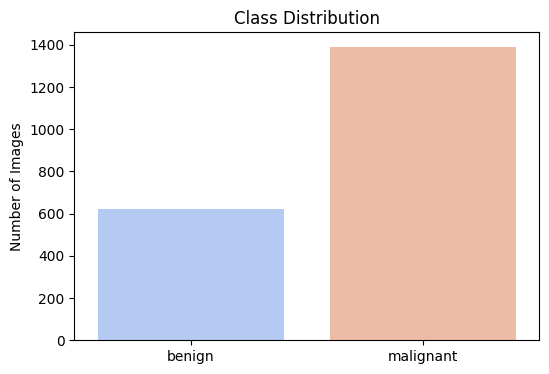

In [6]:
# Count images per class
class_counts = {'benign': 0, 'malignant': 0}
for subdir, _, files in os.walk(base_dir):
    if 'benign' in subdir.lower():
        class_counts['benign'] += len(files)
    elif 'malignant' in subdir.lower():
        class_counts['malignant'] += len(files)

plt.figure(figsize=(6,4))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="coolwarm")
plt.title("Class Distribution")
plt.ylabel("Number of Images")
plt.show()




In [13]:
import os


# Initialize counters
class_counts = {'benign': 0, 'malignant': 0}

# Loop through dataset folders and count files
for subdir, _, files in os.walk(base_dir):
    if 'benign' in subdir.lower():
        class_counts['benign'] += len(files)
    elif 'malignant' in subdir.lower():
        class_counts['malignant'] += len(files)

# Print results neatly
print(f" Image Count Summary for {magnification} Magnification")
print("-" * 50)
print(f"Benign Images   : {class_counts['benign']:,}")
print(f"Malignant Images: {class_counts['malignant']:,}")
print(f"Total Images    : {class_counts['benign'] + class_counts['malignant']:,}")
print("-" * 50)

# Optional — Display as DataFrame
import pandas as pd
df_counts = pd.DataFrame.from_dict(class_counts, orient='index', columns=['Image_Count'])
display(df_counts)


 Image Count Summary for 200X Magnification
--------------------------------------------------
Benign Images   : 623
Malignant Images: 1,390
Total Images    : 2,013
--------------------------------------------------


,Image_Count
benign,623
malignant,1390


In [14]:
import os
import pandas as pd


# Define base paths for both magnifications
base_path = "/content/breakhis_dataset/final_dataset/dataset_cancer_v1/classificacao_binaria"
magnifications = ["200X", "400X"]

# Dictionary to store results
results = {}

# Loop over magnifications and count files
for mag in magnifications:
    mag_dir = os.path.join(base_path, mag)
    class_counts = {'benign': 0, 'malignant': 0}

    for subdir, _, files in os.walk(mag_dir):
        if 'benign' in subdir.lower():
            class_counts['benign'] += len(files)
        elif 'malignant' in subdir.lower():
            class_counts['malignant'] += len(files)

    results[mag] = class_counts

# Convert to DataFrame for nice display
df = pd.DataFrame(results).T
df['Total'] = df['benign'] + df['malignant']

# Display results
print("IMAGE COUNT SUMMARY — 200X vs 400X MAGNIFICATION")
print("-" * 60)
display(df)

# Print formatted summary
for mag in magnifications:
    print(f" {mag} Magnification:")
    print(f"   Benign Images   : {results[mag]['benign']:,}")
    print(f"   Malignant Images: {results[mag]['malignant']:,}")
    print(f"   Total Images    : {results[mag]['benign'] + results[mag]['malignant']:,}")
    print("-" * 50)


IMAGE COUNT SUMMARY — 200X vs 400X MAGNIFICATION
------------------------------------------------------------


,benign,malignant,Total
200X,623,1390,2013
400X,588,1232,1820


 200X Magnification:
   Benign Images   : 623
   Malignant Images: 1,390
   Total Images    : 2,013
--------------------------------------------------
 400X Magnification:
   Benign Images   : 588
   Malignant Images: 1,232
   Total Images    : 1,820
--------------------------------------------------


In [17]:

#  COUNT AND PLOT IMAGES FOR 200X AND 400X MAGNIFICATIONS


import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define base path
base_path = "/content/breakhis_dataset/final_dataset/dataset_cancer_v1/classificacao_binaria"
magnifications = ["200X", "400X"]

# Count images
results = {}
for mag in magnifications:
    mag_dir = os.path.join(base_path, mag)
    class_counts = {'Benign': 0, 'Malignant': 0}
    for subdir, _, files in os.walk(mag_dir):
        if 'benign' in subdir.lower():
            class_counts['Benign'] += len(files)
        elif 'malignant' in subdir.lower():
            class_counts['Malignant'] += len(files)
    results[mag] = class_counts

# Convert to DataFrame
df = pd.DataFrame(results).T
df['Total'] = df['Benign'] + df['Malignant']

# Print summary
print(" IMAGE COUNT SUMMARY — 200X vs 400X MAGNIFICATION")
print("-" * 60)
df


 IMAGE COUNT SUMMARY — 200X vs 400X MAGNIFICATION
------------------------------------------------------------


,Benign,Malignant,Total
200X,623,1390,2013
400X,588,1232,1820


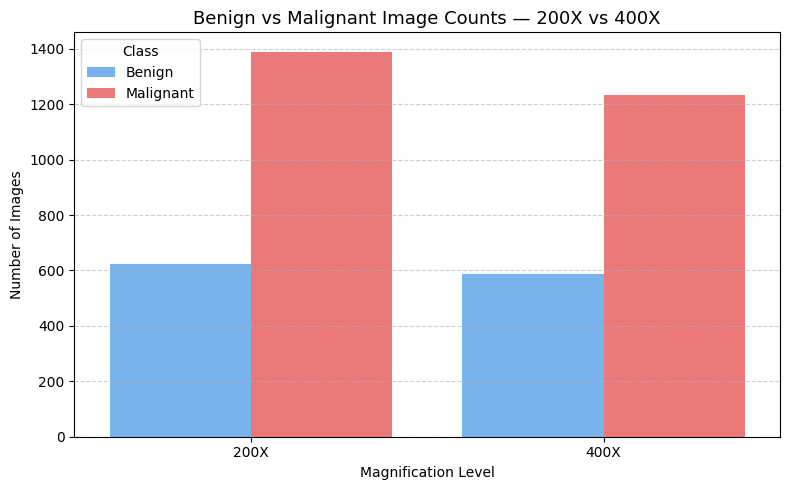

/tmp/ipython-input-2312117270.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df.index, y=df['Total'], palette='pastel')


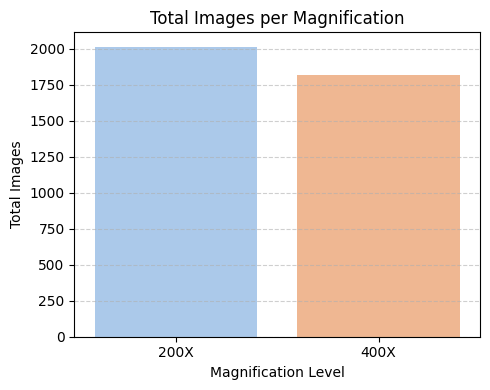

In [16]:

# STEP — PLOT SIDE-BY-SIDE BARS FOR 200X & 400X

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Prepare data (reuse df from previous cell)
df_melted = df[['Benign', 'Malignant']].reset_index().melt(
    id_vars='index', var_name='Class', value_name='Count'
)
df_melted.rename(columns={'index': 'Magnification'}, inplace=True)

# Plot
plt.figure(figsize=(8,5))
sns.barplot(
    data=df_melted,
    x='Magnification',
    y='Count',
    hue='Class',
    palette=['#66b3ff', '#ff6666'],
    dodge=True
)

plt.title("Benign vs Malignant Image Counts — 200X vs 400X", fontsize=13)
plt.xlabel("Magnification Level")
plt.ylabel("Number of Images")
plt.legend(title="Class")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Also show total comparison (optional)
plt.figure(figsize=(5,4))
sns.barplot(x=df.index, y=df['Total'], palette='pastel')
plt.title("Total Images per Magnification")
plt.xlabel("Magnification Level")
plt.ylabel("Total Images")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


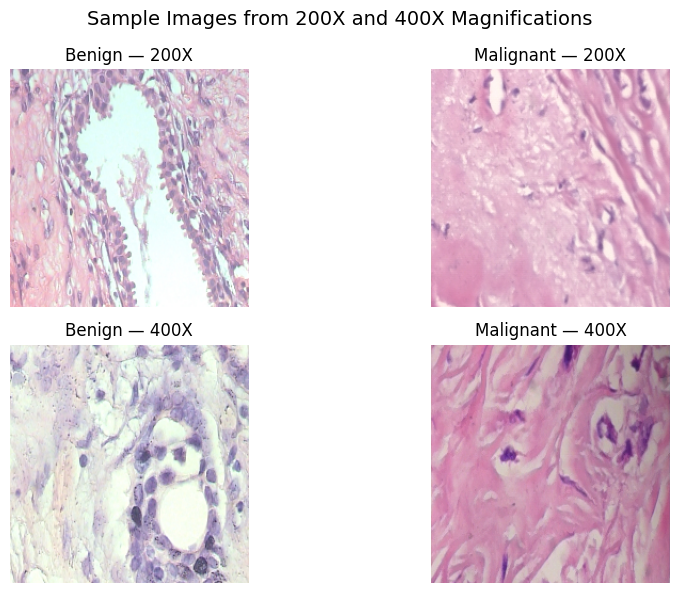

In [18]:

#  DISPLAY SAMPLE IMAGES FROM 200X AND 400X DATASETS

import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Define base paths for both magnifications
base_path = "/content/breakhis_dataset/final_dataset/dataset_cancer_v1/classificacao_binaria"
magnifications = ["200X", "400X"]

# Prepare list to store samples (label, magnification, path)
sample_paths = []

for mag in magnifications:
    mag_dir = os.path.join(base_path, mag)
    for label in ['benign', 'malignant']:
        for root, _, files in os.walk(mag_dir):
            if label in root.lower() and files:
                # randomly pick one image per class per magnification
                sample_paths.append((label, mag, os.path.join(root, random.choice(files))))
                break


# Plot samples

plt.figure(figsize=(10, 6))

for i, (label, mag, path) in enumerate(sample_paths):
    img = Image.open(path)
    plt.subplot(2, 2, i + 1)
    plt.imshow(img)
    plt.title(f"{label.capitalize()} — {mag}")
    plt.axis('off')

plt.suptitle("Sample Images from 200X and 400X Magnifications", fontsize=14)
plt.tight_layout()
plt.show()


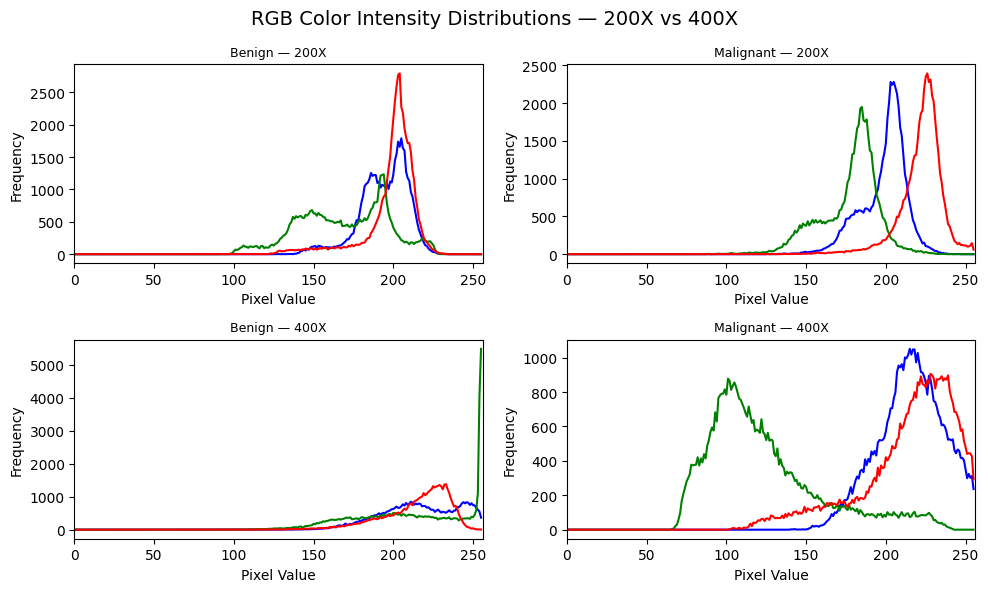

In [19]:
# =============================================================
# STEP — RGB COLOR INTENSITY HISTOGRAMS FOR 200X & 400X
# =============================================================

import cv2
import matplotlib.pyplot as plt
import os, random

# Define base path
base_path = "/content/breakhis_dataset/final_dataset/dataset_cancer_v1/classificacao_binaria"
magnifications = ["200X", "400X"]

# Function to plot RGB histogram for an image
def plot_rgb_hist(image_path, title, subplot_index):
    img = cv2.imread(image_path)
    colors = ('b', 'g', 'r')
    plt.subplot(2, 2, subplot_index)
    for i, col in enumerate(colors):
        hist = cv2.calcHist([img], [i], None, [256], [0, 256])
        plt.plot(hist, color=col)
    plt.title(title, fontsize=9)
    plt.xlim([0, 256])
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")

# Collect random images: 1 benign + 1 malignant from each magnification
sample_images = []
for mag in magnifications:
    mag_dir = os.path.join(base_path, mag)
    for label in ['benign', 'malignant']:
        for root, _, files in os.walk(mag_dir):
            if label in root.lower() and files:
                random_img = os.path.join(root, random.choice(files))
                sample_images.append((label, mag, random_img))
                break

# Plot histograms
plt.figure(figsize=(10, 6))
for idx, (label, mag, path) in enumerate(sample_images):
    plot_rgb_hist(path, f"{label.capitalize()} — {mag}", idx + 1)

plt.suptitle("RGB Color Intensity Distributions — 200X vs 400X", fontsize=14)
plt.tight_layout()
plt.show()
